In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelBinarizer, scale
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [5]:
from tqdm import tqdm
from xgboost import XGBClassifier

/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
import os
from sys import argv
import pdb

In [ ]:
mpl.style.use('ggplot')
mpl.rcParams['font.size'] = 12

In [7]:
np.random.seed(24)
torch.manual_seed(24)

# baseline
bkg_WZlvll.csv
(6713.955682059312, 387.68207095283077)
Original: 6713.956 Final 387.682 Eff 5.774
SFOS0 Original: 58.512 Final 30.040 Eff 51.340
SFOS1 Original: 3270.974 Final 171.423 Eff 5.241
SFOS2 Original: 3355.089 Final 163.936 Eff 4.886
bkg_WZqqll.csv
(0.008658278097300479, 0.00028139514870417006)
Original: 0.009 Final 0.000 Eff 3.250
SFOS0 Original: 0.000 Final 0.000 Eff 0.000
SFOS1 Original: 0.004 Final 0.000 Eff 1.875
SFOS2 Original: 0.004 Final 0.000 Eff 4.036
signal_WpWpWm.csv
(24.15797396656229, 10.584578019860624)
Original: 24.158 Final 10.585 Eff 43.814
SFOS0 Original: 5.949 Final 3.486 Eff 58.602
SFOS1 Original: 11.973 Final 4.798 Eff 40.075
SFOS2 Original: 6.194 Final 2.271 Eff 36.659
signal_WmWpWm.csv
(14.276670433050755, 6.16103801415841)
Original: 14.277 Final 6.161 Eff 43.155
SFOS0 Original: 3.484 Final 2.020 Eff 57.993
SFOS1 Original: 7.054 Final 2.779 Eff 39.405
SFOS2 Original: 3.712 Final 1.341 Eff 36.140
Done!

In [82]:
baseline_signal_eff = (10.585 + 6.161) / (24.158 + 14.277)
baseline_bg_eff = 387.682/6713.956
baseline_signal = [3.486 + 2.020, 4.798 + 2.779, 2.271 + 1.341]
baseline_bg = [30.040, 171.423, 163.936]

In [9]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [10]:
def get_data(data_dir):
    fs = [data_dir + f for f in os.listdir(data_dir) if ('signal' in f or 'WZ' in f) and f[0] != '.']
    df = pd.DataFrame()

    for f in fs:
        print f
        new_df = pd.read_csv(f)
        df = pd.concat([df, new_df], ignore_index = True)
        df.index = range(len(df))

    return df

In [11]:
def add_cl_ix(df):
    df['is_sig'] = [1 if 'signal' in val else 0 for val in df.cl.values]
    return df

In [12]:
class WWdataset(Dataset):

    def __init__(self, pd_dataset, non_input=None):
        self.dataset = pd_dataset
        
        self.non_input = ['runNumber', 'lbNumber', 'eventNumber', 'SFOS', 'is_sig', 'weight', 'cl', 'preds']
        if self.non_input is not None:
            self.non_input += non_input
        self.input_vars = [col for col in self.dataset.columns if not col in self.non_input]
        
        self.scale_dataset()
        
        self.target_var = ['is_sig']
        self.weight_var = ['weight']
        
        self.input_np = self.dataset[self.input_vars].as_matrix().astype(dtype=np.float32)
        self.target_np = self.dataset[self.target_var].as_matrix().astype(dtype=int)
        self.weight_np = self.dataset[self.weight_var].as_matrix().astype(dtype=np.float32)

        self.inputs = torch.from_numpy(self.input_np)
        self.target = torch.from_numpy(self.target_np)
        self.weight = torch.from_numpy(self.weight_np)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        target = self.target[idx]
        weight = self.weight[idx]
        return inputs, target, weight

    def n_input(self):
        return len(self.input_vars)
    
    def scale_dataset(self):
        continuous_cols = [column for column in self.input_vars
                           if self.dataset[column].dtype is np.dtype('float64')]
        self.dataset.loc[:, continuous_cols] = scale(self.dataset[continuous_cols])

In [13]:
def net_logistic_regression(n_input):
    model = torch.nn.Sequential(
        torch.nn.Linear(n_input, 2),
    )
    return model

In [14]:
def net_deep_logistic_regression(n_input):
    model = torch.nn.Sequential(
        torch.nn.Linear(n_input, 200),
        torch.nn.ReLU(),
        torch.nn.Linear(200, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 2),
    )
    return model

In [15]:
def train_xgb_classifier(train_dataset):
    model = XGBClassifier()
    model.fit(train_dataset.input_np, train_dataset.target_np, sample_weight=train_dataset.weight_np)
    return model

In [16]:
def split_dataset(pandas_dataset, non_input=None, training_fraction=0.7):
    n_switch_train = int( len(pandas_dataset) * training_fraction)
    n_switch_test = int( len(pandas_dataset) * (training_fraction+1.)/2.)

    train_dataset_aux = pandas_dataset[:n_switch_train]
    test_dataset_aux = pandas_dataset[n_switch_train:n_switch_test]
    val_dataset_aux = pandas_dataset[n_switch_test:]

    train_dataset = WWdataset(train_dataset_aux, non_input)
    test_dataset = WWdataset(test_dataset_aux, non_input)
    val_dataset = WWdataset(val_dataset_aux, non_input)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=True, num_workers=2)    
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=200, shuffle=True, num_workers=2)
    
    return train_dataset, test_dataset, val_dataset, trainloader, testloader, valloader

In [17]:
data_dir = "../../data/"
pandas_dataset = add_cl_ix(get_data(data_dir))

../../data/bkg_WZqqll.csv
../../data/signal_WmWpWm.csv
../../data/bkg_WZlvll.csv
../../data/signal_WpWpWm.csv


In [18]:
non_input = ['l0_m', 'l1_m', 'l2_m', 'SF0S']
train_fraction = 0.7
pandas_dataset = shuffle(pandas_dataset)
train_dataset, test_dataset, val_dataset, trainloader, testloader, valloader = split_dataset(pandas_dataset, non_input=non_input, training_fraction=0.7)

/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
net_logi = net_logistic_regression(train_dataset.n_input())
net_deep = net_deep_logistic_regression(train_dataset.n_input())
criterion = nn.CrossEntropyLoss(reduce=False)

# Training

In [20]:
def compute_loss_batch(batch, net):
    inputs, label, weight = batch
    inputs, label, weight = Variable(inputs), Variable(label), Variable(weight)

    output = net(inputs)
    losses = criterion(output, label.squeeze())
    loss = (losses * weight.squeeze()).sum()

    return loss

def compute_loss_epoch(loader, net):
    loss = 0.
    for i, batch in enumerate(loader):
        loss += compute_loss_batch(batch, net).data[0]
    loss /= len(loader)
    return loss

def train_model(trainloader, valloader, net, criterion, n_epochs=6):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(n_epochs):
        print
        print "epoch: ", epoch
        running_loss = 0.
        for i, batch in enumerate(trainloader):

            optimizer.zero_grad()
            loss = compute_loss_batch(batch, net)
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]
            # if i % 200 == 199:    # print every 200 mini-batches
            #   print "batch:  {}, loss: {}".format(i+1, running_loss/(i+1))
        print "running loss: ", running_loss/len(trainloader)
        print "train loss: ", compute_loss_epoch(trainloader, net)        
        print "val loss: ", compute_loss_epoch(valloader, net)

### Train logistic regression

In [32]:
train_model(trainloader, valloader, net_logi, criterion, n_epochs=8)


epoch:  0
running loss:  0.400831113935
train loss:  0.169261838505
val loss:  0.168446540885

epoch:  1
running loss:  0.129466209047
train loss:  0.103742120691
val loss:  0.10365569397

epoch:  2
running loss:  0.092404544835
train loss:  0.0849556383514
val loss:  0.0850872026283

epoch:  3
running loss:  0.0823320949329
train loss:  0.0807812356483
val loss:  0.0808721311772

epoch:  4
running loss:  0.0805354705742
train loss:  0.0802799206236
val loss:  0.0804846528179

epoch:  5
running loss:  0.0803673663065
train loss:  0.0803712508315
val loss:  0.0804931929027

epoch:  6
running loss:  0.0803745014071
train loss:  0.0805003886074
val loss:  0.080753680857

epoch:  7
running loss:  0.0803709918708
train loss:  0.0803156777583
val loss:  0.0804251000667


### Train deep logistic regression

In [21]:
train_model(trainloader, valloader, net_deep, criterion, n_epochs=6)


epoch:  0
running loss:  0.0868044197923
train loss:  0.0736642538449
val loss:  0.0738139951597

epoch:  1
running loss:  0.0702854729891
train loss:  0.064699654907
val loss:  0.065091199348

epoch:  2
running loss:  0.06265489128
train loss:  0.0602580629326
val loss:  0.0612896693901

epoch:  3
running loss:  0.0589481534585
train loss:  0.0575517890682
val loss:  0.0591583517413

epoch:  4
running loss:  0.0572587635354
train loss:  0.0560092648333
val loss:  0.0574866888311

epoch:  5
running loss:  0.0561370757357
train loss:  0.057242090391
val loss:  0.0595140281526


### Train XGBoost

In [29]:
xgb_model = train_xgb_classifier(train_dataset)

/usr/lib64/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/lib64/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Prediction and Signficance

In [22]:
def add_prediction(dataset, net, field_name):
    input_for_pred = Variable(dataset.inputs)
    predicted_scores = net(input_for_pred)
    predicted_prob = nn.functional.softmax(predicted_scores, dim=1)
    dataset.dataset.loc[:, field_name] = predicted_prob.data.numpy()[:,1]

def add_xgb_prediction(dataset, model, field_name):
    out = model.predict_proba(dataset.input_np)[:, 1]
    dataset.dataset.loc[:, field_name] = out

In [33]:
add_prediction(train_dataset, net_logi, 'logi_pred')
add_prediction(val_dataset, net_logi, 'logi_pred')
add_prediction(test_dataset, net_logi, 'logi_pred')

In [23]:
add_prediction(train_dataset, net_deep, 'deep_pred')
add_prediction(val_dataset, net_deep, 'deep_pred')
add_prediction(test_dataset, net_deep, 'deep_pred')

/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [30]:
add_xgb_prediction(train_dataset, xgb_model, 'xgb_pred')
add_xgb_prediction(val_dataset, xgb_model, 'xgb_pred')
add_xgb_prediction(test_dataset, xgb_model, 'xgb_pred')

## ROC curve

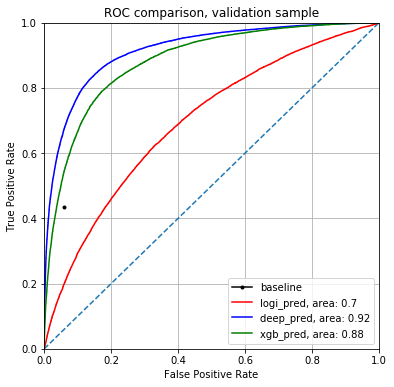

In [102]:
df = val_dataset.dataset

preds = [
    'logi_pred', 
    'deep_pred', 
    'xgb_pred'
]
colors = ['r', 'b', 'g']
rocs = {}

fig = plt.figure(figsize=(6,6))
plt.title('ROC comparison, validation sample')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0,1], [0,1], linestyle='--')
plt.plot([baseline_bg_eff], [baseline_signal_eff], marker='o', markersize=3, color='k', label='baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

for i, var_pred in enumerate(preds):
    rocs[var_pred] = metrics.roc_curve(df['is_sig'].values, df[var_pred].values, sample_weight=df['weight'].values, pos_label=1)
    fpr, tpr, thresholds = rocs[var_pred]
    area = metrics.roc_auc_score(df['is_sig'].values, df[var_pred].values, sample_weight=df['weight'].values)
    # area = metrics.auc(fpr, tpr, reorder=True)
    plt.plot(fpr, tpr, label=var_pred+', area: '+str(round(area, 2)), color=colors[i])
    
plt.legend(loc='best')
plt.show()
#plt.savefig("./plots/roc_curve_train_nn_regression.pdf")

## Compute signal, background and significance

In [38]:
def n_sig_n_bkg(df, SF0S, n_bins, plot):
    df = df[df['SFOS'] == SF0S] 

    x_bins = np.linspace(0, 1, n_bins)
    fig = plt.figure(figsize=(10,6))
    gs = gridspec.GridSpec(3, 1)
    ax = plt.subplot(gs[0,:])
    plt.title('NN Regression Separability on train sample, SF0S = {}'.format(SF0S))
    # n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds, bins=x_bins, weights=df[df.is_sig == 0].weight, color='r')
    n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds.as_matrix(), bins=x_bins, weights=df[df.is_sig == 0].weight.as_matrix(), color='r')
    plt.xlim([0, 1])
    plt.yscale('log')
    plt.ylabel(r'Weighted Background Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='red', label='Background')])
    ax1 = plt.subplot(gs[1,:])
    n_sig,bins,paint = plt.hist(df[df.is_sig == 1].preds.as_matrix(), bins=x_bins, weights=df[df.is_sig == 1].weight.as_matrix(), color='g')
    plt.xlim([0, 1])
    plt.yscale('log')
    plt.ylabel(r'Weighted Signal Counts', size=9)
    plt.legend(handles=[mpatches.Patch(color='green', label='Signal')])
    ax2 = plt.subplot(gs[2,:])
    plt.bar((x_bins[:-1] + x_bins[1:]) / 2., n_sig / np.sqrt(n_bkg), width=x_bins[1] - x_bins[0], color='k')
    plt.xlim([0, 1])
    plt.ylabel(r'Significance ($S/\sqrt{B})$', size=9)
    plt.xlabel('Probability Event is a Signal')

    plt.tight_layout()
    if plot==True:
        plt.show()
    return n_sig, n_bkg

In [109]:
def compute_significance(sig, bg):
    return np.sqrt(2*( (sig + bg)*np.log(1+sig/bg) -sig))

In [158]:
pandas_dataset = test_dataset.dataset
#pandas_dataset = pd.concat([test_dataset.dataset, train_dataset.dataset])
#pandas_dataset = pd.concat([test_dataset.dataset, train_dataset.dataset, val_dataset.dataset])
scale_factor = 1./0.15
pred_variable = 'deep_pred'

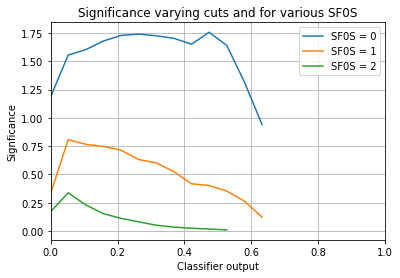

In [159]:
significance = []
signal = []
background = []
probability_cuts = np.linspace(0, 1, 20)
for SF0S in range(3):
    significance.append([])
    signal.append([])
    background.append([])
    for p in probability_cuts:
        sig = pandas_dataset[(pandas_dataset['SFOS'] == SF0S)
                                 & (pandas_dataset[pred_variable] > p)
                                 & (pandas_dataset['is_sig'] == 1)]['weight'].sum()
        bg = pandas_dataset[(pandas_dataset['SFOS'] == SF0S)
                                 & (pandas_dataset[pred_variable] > p)
                                 & (pandas_dataset['is_sig'] == 0)]['weight'].sum()
        
        # significance[SF0S].append(sig/np.sqrt(bg))
        significance[SF0S].append( compute_significance(scale_factor*sig, scale_factor*bg) )
        
        signal[SF0S].append(sig)
        background[SF0S].append(bg)
    plt.plot(probability_cuts, significance[SF0S], label="SF0S = {}".format(SF0S))

plt.legend(loc='best')
plt.title('Significance varying cuts and for various SF0S')
plt.xlabel('Classifier output')
plt.ylabel('Signficance')
plt.xlim((0,1))
plt.grid()
plt.show()

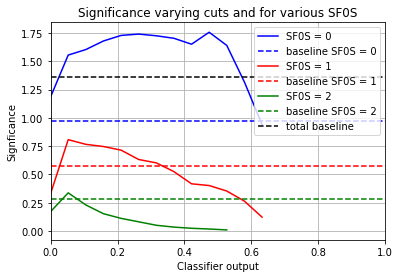

In [160]:
significance = []
signal = []
background = []
probability_cuts = np.linspace(0, 1, 20)
colors = ['b', 'r', 'g']
total_bs_significance = 0.

for SF0S in range(3):
    significance.append([])
    signal.append([])
    background.append([])
    for p in probability_cuts:
        sig = pandas_dataset[(pandas_dataset['SFOS'] == SF0S)
                                 & (pandas_dataset[pred_variable] > p)
                                 & (pandas_dataset['is_sig'] == 1)]['weight'].sum()
        bg = pandas_dataset[(pandas_dataset['SFOS'] == SF0S)
                                 & (pandas_dataset[pred_variable] > p)
                                 & (pandas_dataset['is_sig'] == 0)]['weight'].sum()
        
        # significance[SF0S].append(sig/np.sqrt(bg))
        significance[SF0S].append(compute_significance(scale_factor*sig, scale_factor*bg))
        
        signal[SF0S].append(sig)
        background[SF0S].append(bg)
    plt.plot(probability_cuts, significance[SF0S], label="SF0S = {}".format(SF0S), color=colors[SF0S])
    baseline_significance = compute_significance(baseline_signal[SF0S], baseline_bg[SF0S])
    total_bs_significance += baseline_significance**2
    plt.plot([0,1], [baseline_significance, baseline_significance], 
             linestyle='--', 
             label="baseline SF0S = {}".format(SF0S), 
             color=colors[SF0S])

plt.plot([0,1], [total_bs_significance, total_bs_significance], 
             linestyle='--', 
             label="total baseline", 
             color='black')

plt.legend(loc='best')
plt.title('Significance varying cuts and for various SF0S')
plt.xlabel('Classifier output')
plt.ylabel('Signficance')
plt.xlim((0,1))
plt.grid()
plt.show()

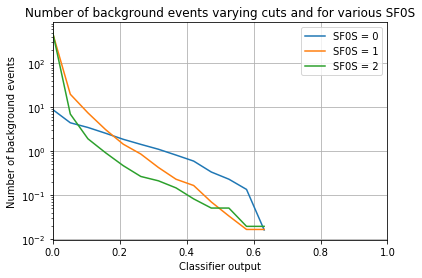

In [113]:
for SF0S in range(3):
    plt.plot(probability_cuts, background[SF0S], label="SF0S = {}".format(SF0S))

plt.legend(loc='best')
plt.title('Number of background events varying cuts and for various SF0S')
plt.xlabel('Classifier output')
plt.ylabel('Number of background events')
plt.xlim((0,1))
plt.yscale('log')
plt.grid()
plt.show()

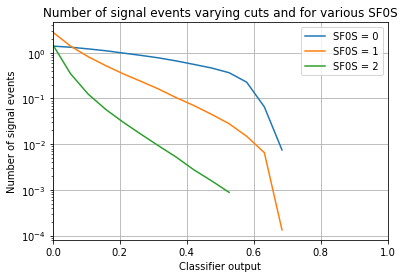

In [114]:
for SF0S in range(3):
    plt.plot(probability_cuts, signal[SF0S], label="SF0S = {}".format(SF0S))

plt.legend(loc='best')
plt.title('Number of signal events varying cuts and for various SF0S')
plt.xlabel('Classifier output')
plt.ylabel('Number of signal events')
plt.xlim((0,1))
plt.yscale('log')
plt.grid()
plt.show()

# 2Dplots

In [78]:
pandas_dataset = val_dataset.dataset
pred_variable = 'deep_pred'

figures = []
for var in val_dataset.input_vars:
    colors = ['r', 'b']
    title = {0: 'background', 1: 'signal'}
    
    f, axes = plt.subplots(1, 2, sharey=True)
    for sig in [0, 1]:        
        x = pandas_dataset[pandas_dataset['is_sig'] == sig][var]
        y = pandas_dataset[pandas_dataset['is_sig'] == sig][pred_variable]
        weight = pandas_dataset[pandas_dataset['is_sig'] == sig]['weight']
        
        h = axes[sig].hist2d(x, y, weights=weight, bins=20, norm=LogNorm())
        axes[sig].set_ylabel('classifier output')
        axes[sig].set_xlabel(var)
        axes[sig].set_xlim([-3, 20])
        axes[sig].set_title(title[sig] + ', corr: {:.2f}'.format(corr(x, y, weight)))
    #f.colorbar(h[3]) 
    # plt.show()
    figures.append(f)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("2D_plots.pdf")
for fig in figures:
    pdf.savefig( fig )
pdf.close()

In [144]:
len(train_dataset.dataset)/float(len(val_dataset.dataset))

4.666612201071416